In [1]:
!pip install transformers

     |████████████████████████████████| 675kB 3.4MB/s 
     |████████████████████████████████| 1.1MB 9.1MB/s 
     |████████████████████████████████| 890kB 14.6MB/s 
     |████████████████████████████████| 3.8MB 28.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=847cbcdfcb834b1b29dfa90eaa8d0dd13457596c11bdcbe41caebb7c94a20942
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import transformers
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from torch import nn, optim
from torch.utils import data

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)


HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


device(type='cpu')

In [3]:

!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 32.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
7.17MB [00:00, 110MB/s]


In [4]:
df = pd.read_csv('reviews.csv')
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


Text(0.5, 0, 'review score')

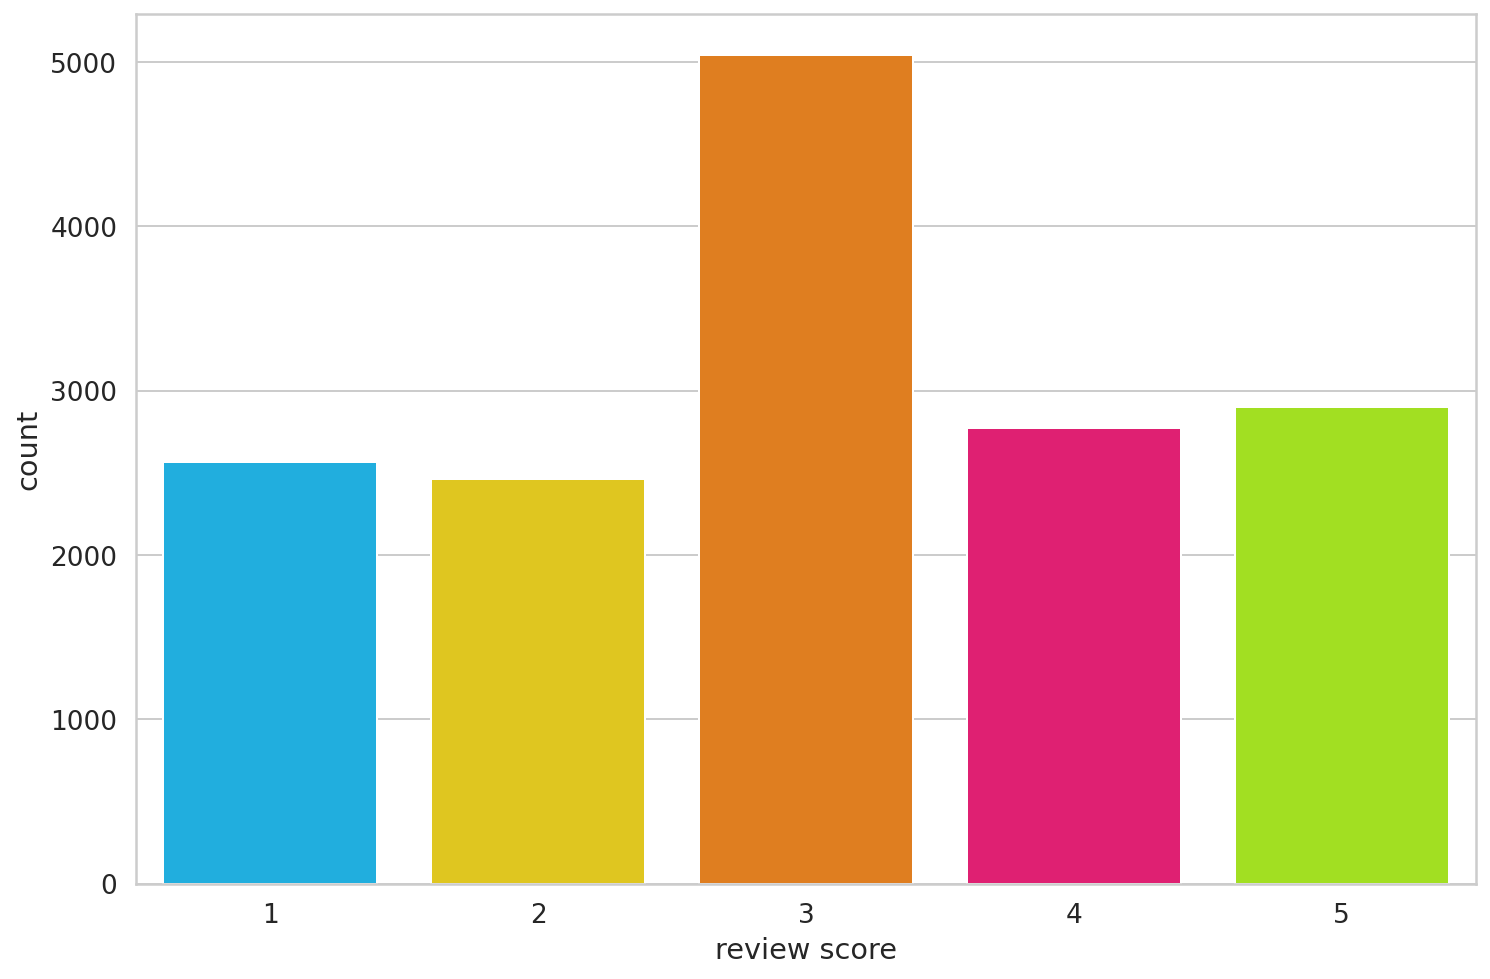

In [6]:
sns.countplot(df.score)
plt.xlabel('review score')

In [7]:
def to_sentiment (rating):
  rating = int(rating)
  if rating <=2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2

In [8]:
df['sentiment'] = df.score.apply(to_sentiment)

In [9]:
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo,0
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo,0
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo,0
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo,0
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo,0


In [10]:
class_names = ['negative', 'neutral', 'positive']

[Text(0, 0, 'negative'), Text(0, 0, 'neutral'), Text(0, 0, 'positive')]

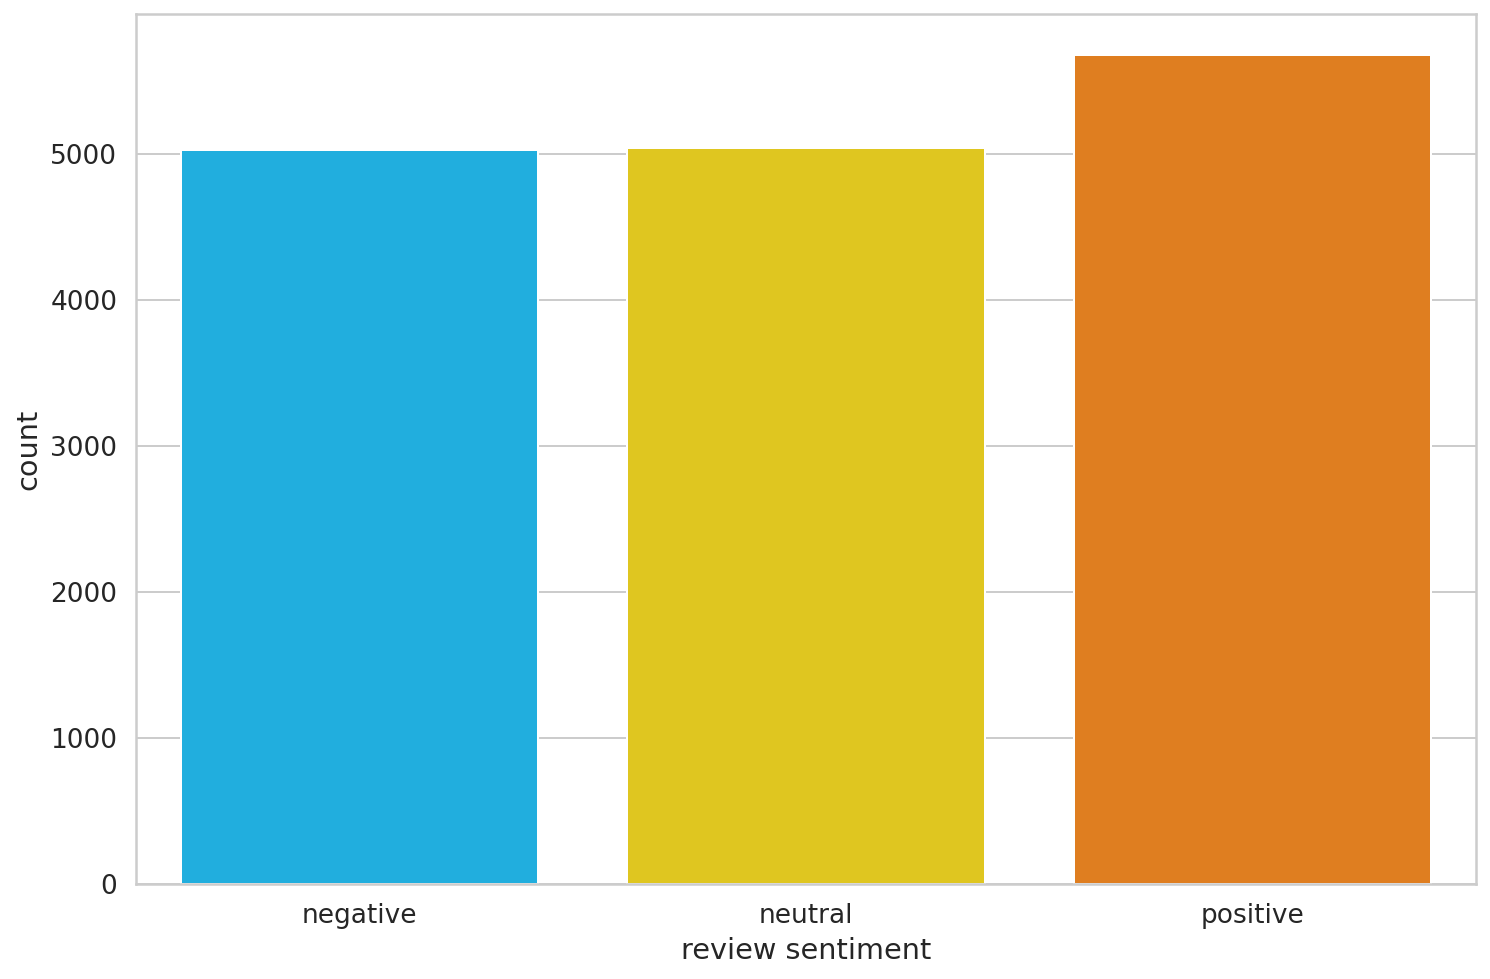

In [11]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

In [12]:
#Data Preprocessing

In [13]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

In [14]:
sample_text = 'When I went to beach, I swam with my girlfriend'

In [15]:
tokens = tokenizer.tokenize(sample_text)

In [17]:
print(tokens)

['when', 'i', 'went', 'to', 'beach', ',', 'i', 'swam', 'with', 'my', 'girlfriend']


In [18]:
token_ids = tokenizer.convert_tokens_to_ids(tokens)

In [20]:
print(token_ids)

[2043, 1045, 2253, 2000, 3509, 1010, 1045, 16849, 2007, 2026, 6513]


In [21]:
### Special Tokens

In [22]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [23]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [24]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [25]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [35]:
encoding = tokenizer.encode_plus(sample_text, 
                            max_length = 32,
                            add_special_tokens = True ,
                            pad_to_max_length = True,
                            return_attention_mask = True,
                            return_token_type_ids = False,
                            return_tensors = 'pt'
                            )

encoding.keys()


dict_keys(['input_ids', 'attention_mask'])

In [36]:
encoding

{'input_ids': tensor([[  101,  2043,  1045,  2253,  2000,  3509,  1010,  1045, 16849,  2007,
          2026,  6513,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])}

In [41]:
len(encoding['input_ids'][0])

32

In [42]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [43]:
##Choosing Sequence Length

In [50]:
token_lens = []
for txt in df.content:
  tokens = tokenizer.encode(txt, max_length = 512)
  token_lens.append(len(tokens))

In [55]:
len(token_lens)

15746

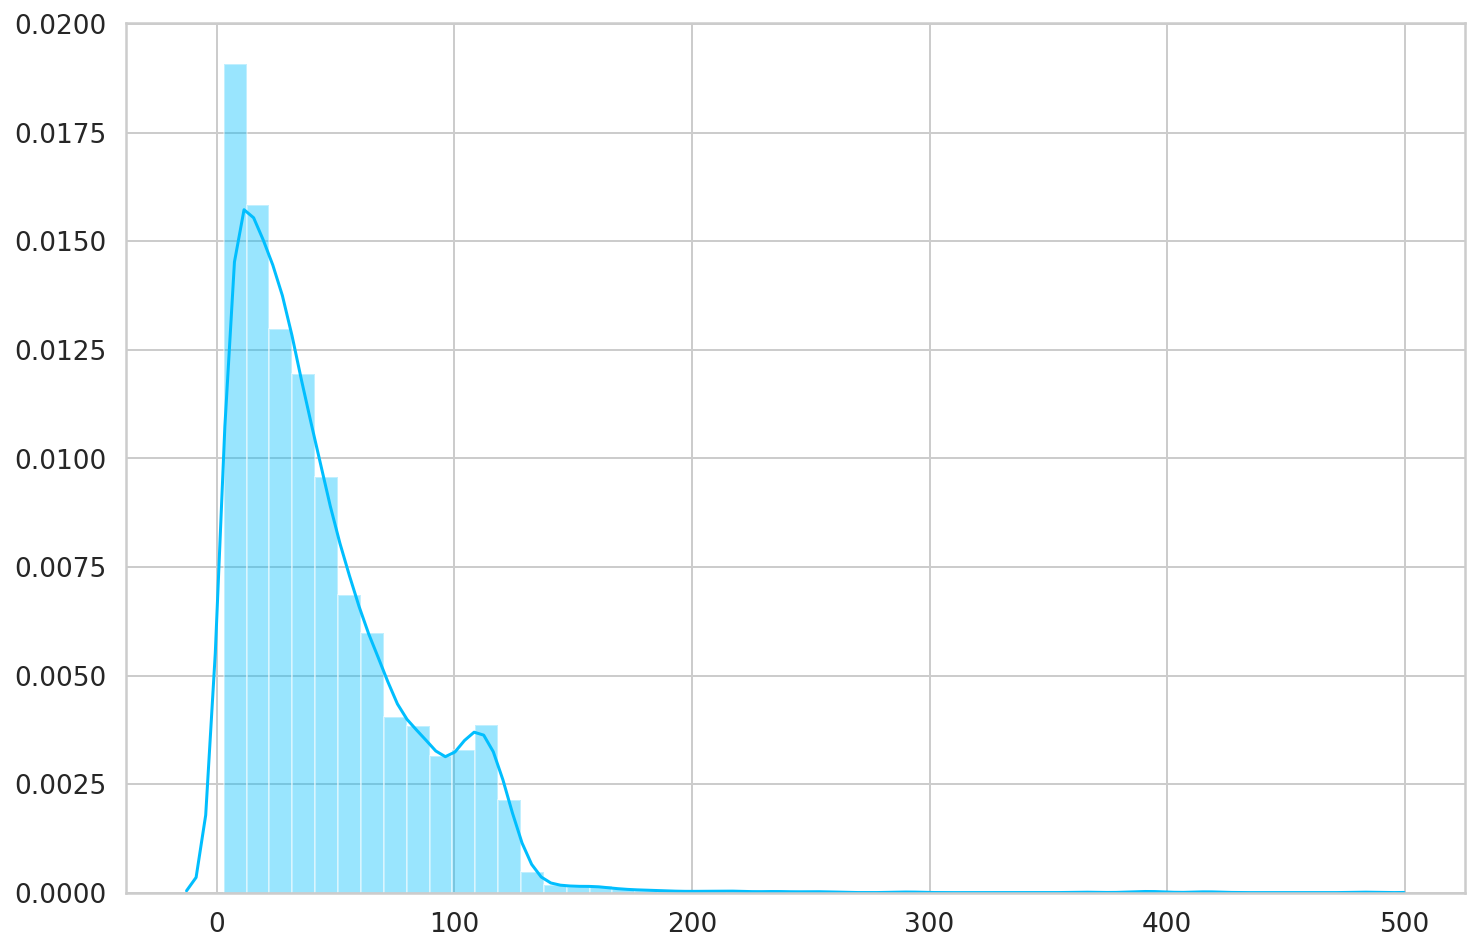

In [59]:
sns.distplot(token_lens)

In [60]:
### Create a Dataset

In [61]:
class GPReviewDataset (data.Dataset):

  def __init__(self, review, target, tokenizer, max_len):
    self.review = review
    self.target = target 
    self.tokenizer = tokenizer
    self.max_len = max_len 

  def __len__(self):
    return(len(self.review))

  def __getitem__(self, item):
    review = str(self.review[item])
    encoding = tokenizer.encode_plus(
      review,
      max_length = self.max_len,
      add_special_tokens = True ,
      pad_to_max_length = True,
      return_attention_mask = True,
      return_token_type_ids = False,
      return_tensors = 'pt'
    )

    return {
        'input_ids' : encoding['input_ids'],
        'attention_mask' : encoding['attention_mask'],
        'targets' : torch.tensor(self.target[item], dtype = torch.long)
    }




In [62]:
MAX_LEN = 128
BATCH_SIZE = 8
EPOCHS = 20


In [63]:
df_train, df_test = train_test_split(df, test_size = 0.2, random_state = RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size = 0.5, random_state = RANDOM_SEED)

In [66]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(12596, 12)
(1575, 12)
(1575, 12)


In [67]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
      review = df.content.to_numpy(),
      target = df.sentiment.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return data.DataLoader(
      ds,
      batch_size = batch_size,
      num_workers = 4
  )

In [68]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
train_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
train_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)
